In [1]:
import torch
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch.nn.functional as F
import random
import pandas as pd
import math
from ooppnm import wrap_openpnm as pnm_sim
from eval.models_lib import model1
from os import path

def kr_simulation(img_input):
    data_pnm = pnm_sim.Wrap_pnm(im=img_input)
    data_pnm.network_extract()
    data_pnm.add_boundary_pn()
    data_pnm.init_physics()
    data_pnm.invasion_percolation()
    try:
      df_kr = data_pnm.kr_simulation()
    except Exception as e:
      print(e)
      bad_im.append(img_input)
      return pd.DataFrame()

    data_pnm.close_ws()
    return df_kr

def tensor_process(image_tensor):

    image_unflat = image_tensor.detach().cpu()
    image_numpy = image_unflat.numpy()

    return image_numpy

def img_filter(im):
  return im>0.5

# load the model
torch.manual_seed(0)
ex = 1

import init_yaml
f_yaml = init_yaml.Init_yaml().config
model_path = init_yaml.Init_yaml().path_join(f_yaml['model_path']['model_save'],f'ex{ex}/cgan20.pth')
feature_path = init_yaml.Init_yaml().path_join(f_yaml['feature_path'],'features.csv')
img_path = init_yaml.Init_yaml().path_join(f_yaml['img_path']['raw_data'])

df = pd.read_csv(feature_path)

gen = model1.Generator(embed_size=20)
gen.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
gen.eval()


bad_im = []

In [ ]:
#%% fake transport properties visualization


kr_phi = {}
phi_list = [0.2,0.3,0.4]
image_num = 5

img_check = {}

for phi in phi_list:

  # initialize inputs for GAN
  z = torch.randn(image_num,100)
  features = torch.full((image_num,1),phi)
  kr_store_i = []
  img_check_list = []


  with torch.no_grad():
    fake = gen(z,features)
    img = tensor_process(fake)
    img = img_filter(img)
    img_check_list.append(img)
  
  for i in range(image_num):
    
    # perform PNM
    # input should be 3D numpy array
    df_kr = kr_simulation(img[i,0,::])
    kr_store_i.append(df_kr)    
      
  
  kr_phi["{:.2f}".format(phi)] = kr_store_i
  img_check["{:.2f}".format(phi)] = img_check_list

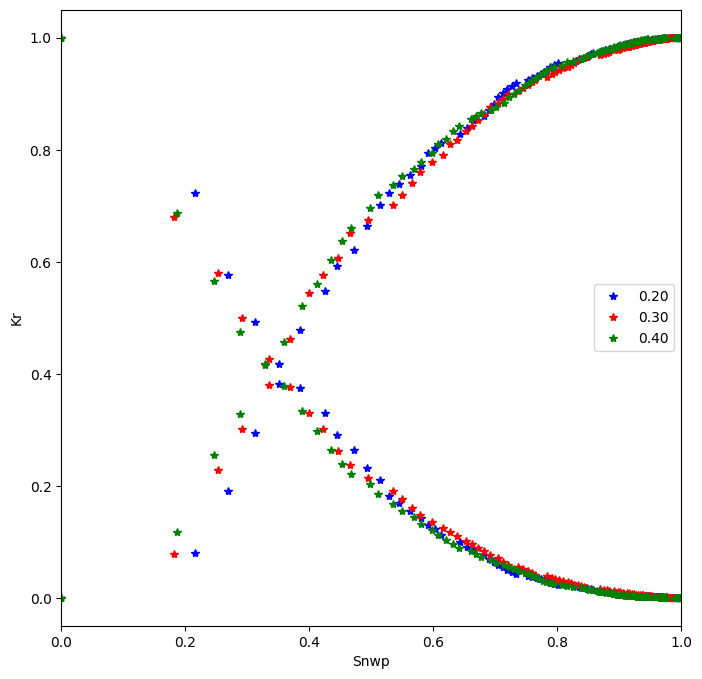

In [2]:
#average df
kr_avg = {}
for porosity in kr_phi.keys():
  kr_avg[porosity] = pd.concat(kr_phi[porosity]).groupby(level=0).mean()

f = plt.figure(figsize=[8,8])
c = ['b*','r*','g*']
for phi,i in zip(kr_avg.keys(),c):
  df = kr_avg[phi]
  plt.plot(df['snwp'], df['krnw'], i, label=phi)
  plt.plot(df['snwp'], df['krw'], i)
plt.xlabel('Snwp')
plt.xlim([0,1])
plt.ylabel('Kr')
plt.legend()

#### Print out porosity

In [4]:
img_check.keys()

dict_keys(['0.20', '0.30', '0.40'])

In [5]:
import porespy as ps
for key in img_check.keys():
    print("\nCheckout: {}".format(key))
    for i in range(len(img_check[key])):
        print(ps.metrics.porosity(img_check[key][i]))


Checkout: 0.20
0.175490665435791

Checkout: 0.30
0.2850955963134766

Checkout: 0.40
0.3700704574584961


#### Check training image data

In [13]:
import porespy as ps
name_phi_small = df.loc[df['phi'] < 0.15,'name'].iloc[0]
name_phi_large = df.loc[df['phi'] > 0.34,'name'].iloc[0]
im_small = init_yaml.Init_yaml().path_join(f_yaml['img_path']['train_data'],name_phi_small)
im_large = init_yaml.Init_yaml().path_join(f_yaml['img_path']['train_data'],name_phi_large)
im_small = np.load(im_small)
im_large = np.load(im_large)
print("Lower porosity is {}".format(ps.metrics.porosity(im_small)))
print("Larger porosity is {}".format(ps.metrics.porosity(im_large)))

Lower porosity is 0.10981893539428711
Larger porosity is 0.340242862701416


In [ ]:
df_kr_s = kr_simulation(im_small)
df_kr_l = kr_simulation(im_large)

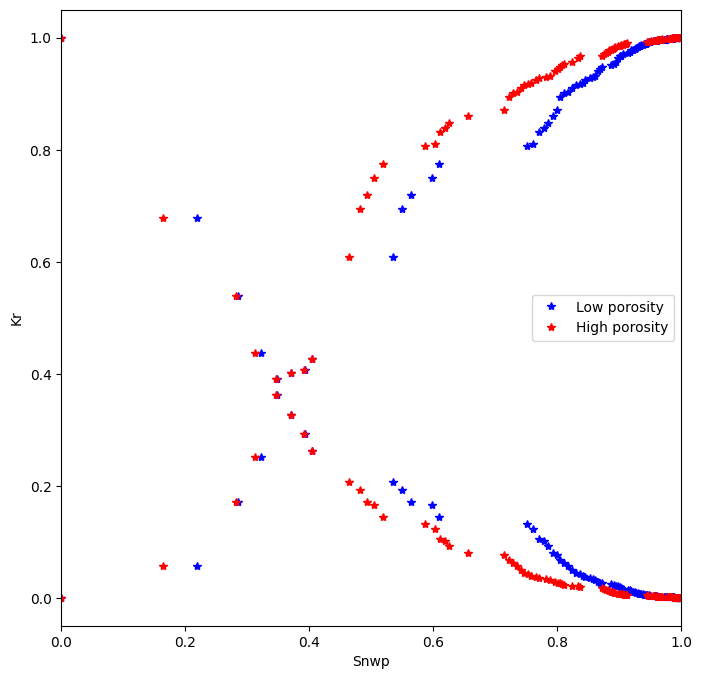

In [15]:
df_kr_s = df_kr_s[0:100]
df_kr_l = df_kr_l[0:100]
f = plt.figure(figsize=[8,8])
c = ['b*','r*']
plt.plot(df_kr_s['snwp'], df_kr_s['krnw'], c[0], label="Low porosity")
plt.plot(df_kr_s['snwp'], df_kr_s['krw'], c[0])
plt.plot(df_kr_l['snwp'], df_kr_s['krnw'], c[1], label="High porosity")
plt.plot(df_kr_l['snwp'], df_kr_s['krw'], c[1])
plt.xlabel('Snwp')
plt.xlim([0,1])
plt.ylabel('Kr')
plt.legend()

In [18]:
import porespy as ps
name_phi_small = df.loc[df['euler'] < -100,'name'].iloc[0]
name_phi_large = df.loc[df['euler'] > 100,'name'].iloc[0]
im_small = init_yaml.Init_yaml().path_join(f_yaml['img_path']['train_data'],name_phi_small)
im_large = init_yaml.Init_yaml().path_join(f_yaml['img_path']['train_data'],name_phi_large)
im_small = np.load(im_small)
im_large = np.load(im_large)
print("Lower Euler porosity is {}".format(ps.metrics.porosity(im_small)))
print("Higher Euler porosity is {}".format(ps.metrics.porosity(im_large)))

Lower porosity is 0.28386783599853516
Larger porosity is 0.13376140594482422


In [ ]:
df_kr_s = kr_simulation(im_small)
df_kr_l = kr_simulation(im_large)

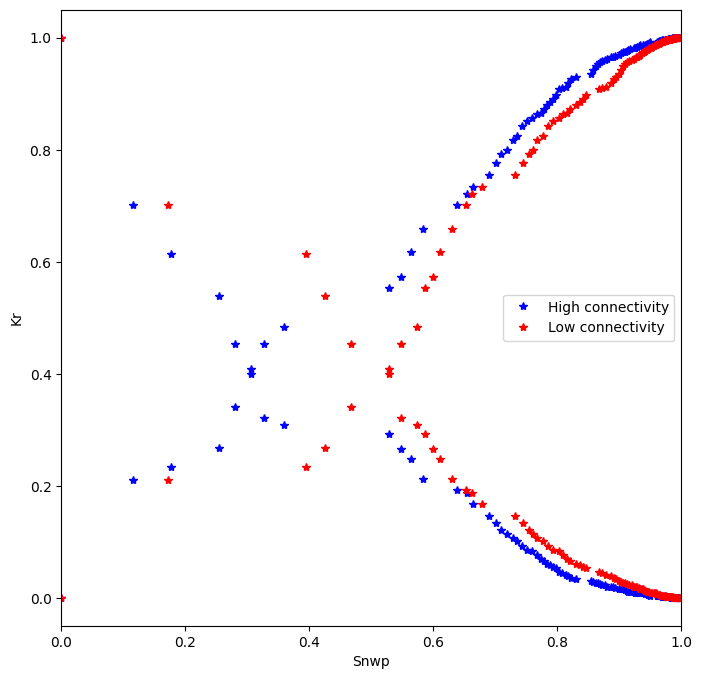

In [21]:
df_kr_s = df_kr_s[0:100]
df_kr_l = df_kr_l[0:100]
f = plt.figure(figsize=[8,8])
c = ['b*','r*']
plt.plot(df_kr_s['snwp'], df_kr_s['krnw'], c[0], label="High connectivity")
plt.plot(df_kr_s['snwp'], df_kr_s['krw'], c[0])
plt.plot(df_kr_l['snwp'], df_kr_s['krnw'], c[1], label="Low connectivity")
plt.plot(df_kr_l['snwp'], df_kr_s['krw'], c[1])
plt.xlabel('Snwp')
plt.xlim([0,1])
plt.ylabel('Kr')
plt.legend()